In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from scipy.constants import epsilon_0, Boltzmann

h_bar = 0.5

def annihilation_operator(N_max=10, f=1, t=0):
    a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)
    for n in range(1, N_max):
        a = a.at[n-1, n].set(jnp.sqrt(n))
    
    return a

def electric_field_operator(N_max=10, f=1, t=0, mode_volume=1):
    E_0 = jnp.sqrt((h_bar*2*jnp.pi*f)/(epsilon_0*mode_volume))
    E_0 = 1
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    
    return E_0 * (a + a_dagger)

def number_operator(N_max, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return a_dagger@a

def expectation_value_pure(operator, psi):
    return jnp.vdot(psi, operator@psi)

def expectation_value_mixed(operator, rho):
    return jnp.trace(rho@operator)

def thermal_state(N_max, f=1.0, temperature=1/Boltzmann):
    n = jnp.arange(0, N_max)
    E_n = h_bar*2*jnp.pi*f*(n+0.5)
    
    P_n = jnp.exp(-E_n / (Boltzmann*temperature))
    P_n = P_n / jnp.sum(P_n)
    return jnp.diag(P_n)

def coherent_state(alpha, N_max=10, f=1.0):
    n = jnp.arange(0, N_max)
    return jnp.exp(-0.5*jnp.abs(alpha)**2) * alpha**n / jnp.sqrt(jax.scipy.special.factorial(n))

def vacuum_state(N_max=10, f=1.0):
    vac = jnp.zeros(N_max, dtype=jnp.complex128)
    vac = vac.at[0].set(1.0)
    return vac

def displacement_operator(alpha, N_max=10, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return jax.scipy.linalg.expm(alpha*a_dagger - jnp.conj(alpha)*a)

def characteristic_function_mixed(rho, f=1.0, t=0):
    N_max = rho.shape[0]

    def characteristic_fn(eta):
        return jnp.trace(rho @ displacement_operator(eta, N_max=N_max, f=f, t=t))

    def apply_fn(eta_grid):
        flat_eta = eta_grid.reshape(-1)

        def scan_fn(carry, eta):
            val = characteristic_fn(eta)
            return carry, val

        # remat helps prevent backprop memory buildup
        _, results = jax.lax.scan(jax.remat(scan_fn), None, flat_eta)
        return results.reshape(eta_grid.shape)

    return apply_fn

def characteristic_function_pure(psi, f=1.0, t=0):
    rho = jnp.outer(psi, psi.conj().T)
    N_max = rho.shape[0]

    return characteristic_function_mixed(rho, f=f, t=t)

def characteristic_function_gaussian(mean, covariance):
    def characteristic_fn(eta):
        xi = jnp.sqrt(2) * jnp.array([jnp.real(eta), jnp.imag(eta)])
        return jax.scipy.linalg.expm(-0.5*xi@covariance@eta + 1j*mean@xi)
    
    return characteristic_fn

def eigenvalue_from_vector(A, v):
    Av = A @ v
    v_normalized = v / jnp.linalg.norm(v)
    return jnp.vdot(v_normalized, Av)

def wigner_function(alpha, characteristic_fn, grid_size=80, limit=4.0):
    dx = 2 * limit / grid_size
    x = jnp.linspace(-limit, limit, grid_size)
    y = jnp.linspace(-limit, limit, grid_size)
    xx, yy = jnp.meshgrid(x, y)
    lam = xx + 1j * yy

    lam_flat = lam.reshape(-1)
    chi_vals = characteristic_fn(lam_flat).reshape(lam.shape)

    exponent = jnp.conj(lam) * alpha - lam * jnp.conj(alpha)
    integrand = chi_vals * jnp.exp(exponent)
    integral = jnp.sum(integrand) * dx**2

    return (1 / jnp.pi**2) * integral.real

def coherence_1(rho, t1, t2):
    N_max = rho.shape[0]
    t1 = 0
    t2 = 1
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = jnp.sqrt(
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )
    
    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2, rho)

    return numerator/denominator

def coherence_2(rho, t1, t2):
    N_max = rho.shape[0]
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = (
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )

    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2.conj().T @ a_hat_2 @ a_hat_1, rho)

    return numerator/denominator



In [3]:
# N_max=60
N_max=80
T = 1/Boltzmann
t=0
f = 1
n_hat = number_operator(N_max=N_max, f=f, t=t)
temperature = 1/Boltzmann
rho_th = thermal_state(N_max)
print(expectation_value_mixed(n_hat, rho_th))
print(1/(jnp.exp(h_bar*2*jnp.pi*f/(Boltzmann*T))-1))

/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)


(0.045165706+0j)
0.045165703


In [ ]:
print(coherence_1(rho_th, 0, 1))
print(coherence_2(rho_th, 0, 1))

/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)


(1+0j)
(1.9999988+0j)


In [5]:
vac = vacuum_state(N_max)
alpha = 0.5
print(displacement_operator(alpha, N_max=N_max) @ vac)
print(coherent_state(alpha, N_max=N_max))

/tmp/ipykernel_13461/1179003246.py:47: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  vac = jnp.zeros(N_max, dtype=jnp.complex128)
/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)


[8.8249701e-01+0.j 4.4124842e-01+0.j 1.5600489e-01+0.j 4.5034725e-02+0.j
 1.1258681e-02+0.j 2.5175177e-03+0.j 5.1388610e-04+0.j 9.7115371e-05+0.j
 1.7167733e-05+0.j 2.8612878e-06+0.j 4.5240927e-07+0.j 6.8203306e-08+0.j
 9.8443067e-09+0.j 1.3651598e-09+0.j 1.8242692e-10+0.j 2.3551140e-11+0.j
 2.9438765e-12+0.j 3.5699468e-13+0.j 4.2071818e-14+0.j 4.8259440e-15+0.j
 5.3957640e-16+0.j 5.8885836e-17+0.j 6.2830071e-18+0.j 6.5710385e-19+0.j
 6.7707312e-20+0.j 6.9514966e-21+0.j 7.2837898e-22+0.j 8.1315681e-23+0.j
 1.0214492e-23+0.j 1.4876283e-24+0.j 2.4504359e-25+0.j 4.3151280e-26+0.j
 7.7407392e-27+0.j 1.3756323e-27+0.j 2.3907726e-28+0.j 4.0432603e-29+0.j
 6.6456094e-30+0.j 1.0619420e-30+0.j 1.6514910e-31+0.j 2.5029152e-32+0.j
 3.7028164e-33+0.j 5.3594002e-34+0.j 7.6183175e-35+0.j 1.0691550e-35+0.j
 1.4024465e-36+0.j 7.6395777e-38+0.j 0.0000000e+00+0.j 0.0000000e+00+0.j
 0.0000000e+00+0.j 0.0000000e+00+0.j 0.0000000e+00+0.j 0.0000000e+00+0.j
 0.0000000e+00+0.j 0.0000000e+00+0.j 0.0000000e+00+

In [6]:
a_hat = annihilation_operator(N_max=N_max, f=f, t=t)
print(eigenvalue_from_vector(a_hat, coherent_state(alpha, N_max=N_max)))

/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)


(0.49999997+0j)


In [7]:
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre

alphas = jnp.linspace(-6.0, 6.0, 350)
n = 3

/tmp/ipykernel_13461/1046067386.py:9: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  psi_number = jnp.zeros(N_max, dtype=jnp.complex128).at[n].set(1.0)
/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards 

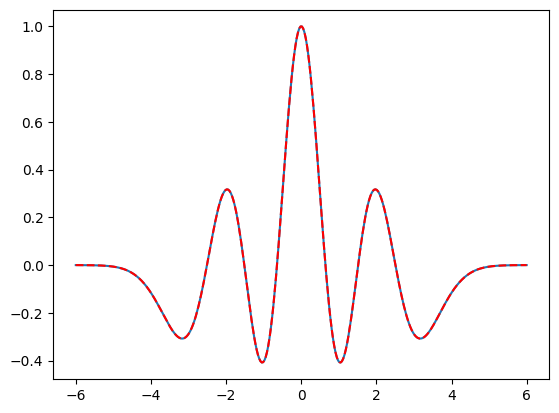

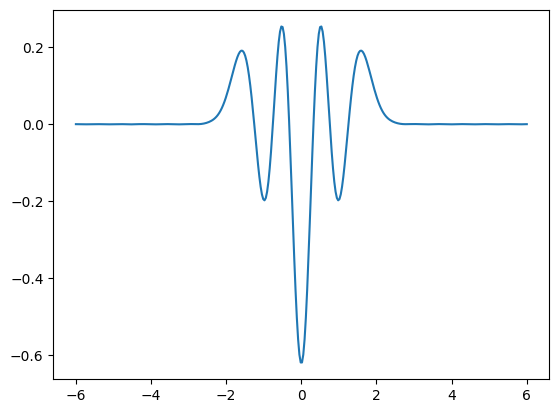

In [ ]:
def chi_number_state(n, eta):
    abs_eta2 = jnp.abs(eta)**2
    return jnp.exp(-0.5 * abs_eta2) * eval_laguerre(n, abs_eta2)



plt.plot(alphas, chi_number_state(n, alphas))

psi_number = jnp.zeros(N_max, dtype=jnp.complex128).at[n].set(1.0)
C = characteristic_function_pure(psi_number)
data = []

plt.plot(alphas, C(jnp.array([alphas]))[0], "r--")
plt.show()

def scan_fn(_, alpha):
    value = wigner_function(alpha, C, 100, 5.0)
    return None, value

_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)

plt.plot(alphas, wigner_vals)


/tmp/ipykernel_13461/1179003246.py:8: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)


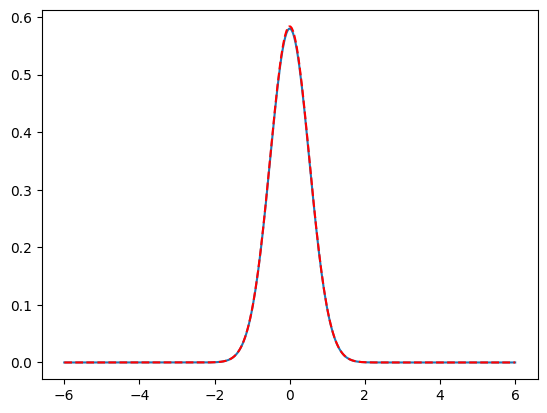

In [9]:
C = characteristic_function_mixed(rho_th)

@jax.remat
def scan_fn(_, alpha):
    # value = wigner_function(alpha, C, 100, 5.0)
    value = wigner_function(alpha, C, 300, jnp.sqrt(N_max/2))
    return None, value

_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)
plt.plot(alphas, wigner_vals)

_n = jnp.arange(rho_th.shape[0])
# n_bar = jnp.sum(_n * jnp.diag(rho_th))
n_bar = 1 / (jnp.exp(h_bar * 2 * jnp.pi * f * (1/(Boltzmann*temperature))) - 1)
wigner_vals_theory = 2/ (jnp.pi*(2*n_bar+1))*jnp.exp(-2*jnp.abs(alphas)**2 / (2*n_bar + 1))
plt.plot(alphas, wigner_vals_theory, "r--")

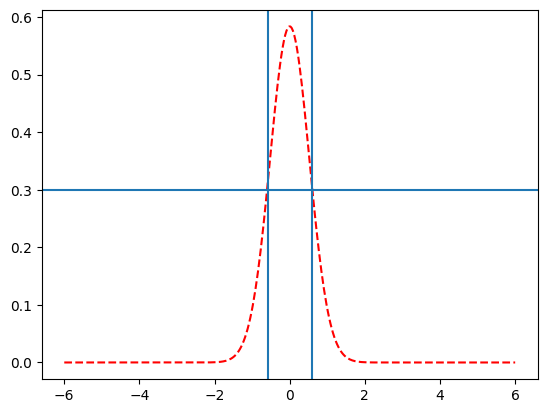

In [10]:
plt.plot(alphas, wigner_vals_theory, "r--")
plt.axvline( 0.5*(2.355*jnp.sqrt(h_bar/2)))
plt.axvline(-0.5*(2.355*jnp.sqrt(h_bar/2)))
plt.axhline(0.3)

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/gravis/_internal/plotting/template_system.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as _pkg_resources


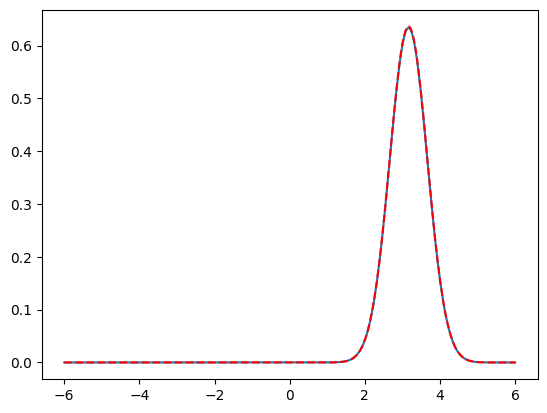

In [11]:
# from simphony.simulation.jax_tools import python_based_scan
psi_coherent = coherent_state(jnp.sqrt(10), N_max=N_max)
C = characteristic_function_pure(psi_coherent)

# @jax.remat
def scan_fn(_, alpha):
    # value = wigner_function(alpha, C, 100, 5.0)
    value = jax.lax.stop_gradient(wigner_function(alpha, C, 450, jnp.sqrt(N_max/2)))
    return None, value

# _, wigner_vals = python_based_scan(scan_fn, init=None, xs=alphas)
_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)
plt.plot(alphas, wigner_vals)

wigner_vals_theory = 2/jnp.pi*jnp.exp(-2*jnp.abs(alphas-jnp.sqrt(10))**2)
plt.plot(alphas, wigner_vals_theory, "r--")
